## 🌀 CYMS Project - Sentinel-1 SAR Wind Monitoring for Tropical Cyclones

<img src="img/cyms.png" alt="CYMS logo" width="150"/> <img src="img/cyclobs.png" alt="CyclObs logo" width="150"/>

This notebook showcases the core of the **CYMS project** (*Cyclone Wind Monitoring from SAR*).  
CYMS aims to provide high-resolution **wind field maps from Sentinel-1 Synthetic Aperture Radar (SAR)** imagery to serve the Tropical Cyclone (TC) community—including both scientific and operational stakeholders.

At the heart of the project is the **CyclObs wind processor**, which transforms SAR backscatter data (normalized radar cross section, NRCS) into ocean surface wind speed. This is accomplished using a **Geophysical Model Function (GMF)** through **Look-Up Tables (LUTs)** that relate radar parameters (e.g. antenna look direction, polarization) to wind vectors.

The ultimate goal of CYMS is to deliver **high‑resolution ocean surface wind observations over storms**, supporting both the **operational monitoring of tropical cyclone structure, intensity, and trajectory** and the creation of **science‑ready SAR products**, based on **Sentinel‑1 data**.

---

### 🌪️ Example: Storm Track Visualization

The figure below illustrates the storm **al122024/KIRK**, observed from **27 September to 10 October 2024**, tracked across the Atlantic Ocean. Each colored swath is a **SAR-derived Level-2 wind speed product**, processed with CyclObs.

<img src="img/al122024.png" alt="Storm track al122024" width="600"/>

This notebook walks through how such a Level-2 wind product is created from **four Sentinel-1 GDR images**, illustrating the reproducible processing pipeline of the CYMS project.

---

### 📚 References

- Mouche A., Chapron B., Zhang B., Husson R. (2017). *Combined Co- and Cross-Polarized SAR Measurements Under Extreme Wind Conditions*. IEEE TGRS, 55(12), 6746–6755. [https://doi.org/10.1109/TGRS.2017.2732508](https://doi.org/10.1109/TGRS.2017.2732508)
- Mouche A., Chapron B., Knaff J., Zhao Y., Zhang B., Combot C. (2019). *Copolarized and Cross‐Polarized SAR Measurements for High‐Resolution Description of Major Hurricane Wind Structures: Application to Irma Category 5 Hurricane*. JGR Oceans, 124(6), 3905–3922. [https://doi.org/10.1029/2019JC015056](https://doi.org/10.1029/2019JC015056)
- Combot C., Mouche A., Knaff J., Zhao Y., Zhao Y., Vinour L., Quilfen Y., Chapron B. (2020). *Extensive High-Resolution Synthetic Aperture Radar (SAR) Data Analysis of Tropical Cyclones: Comparisons with SFMR Flights and Best-Track*. MWR, 148(11), 4545–4563. [https://doi.org/10.1175/MWR-D-20-0005.1](https://doi.org/10.1175/MWR-D-20-0005.1)

### 🛰️ ESA Funding Acknowledgement

This work is supported by funding from the **European Space Agency (ESA)** through the following projects:

- **[Ocean4study (2015–2020)](url)**, Contract No. **4000115170/15**
- **[CYMS (Scaling‑up Cyclone Monitoring Service, 2020–2022)](https://eo4society.esa.int/projects/cyms/)**, Contract No. **4000129822/19**
- **[MPCS1 (2023–2024)](https://sentiwiki.copernicus.eu/__attachments/1673968/DI-MPC-LOP-MPC-0583%20-%20Sentinel-1%20Level-2%20Ocean%20Processor%20Master%20ATBD%202024%20-%201.2.pdf?inst-v=036311ce-c427-48a7-bdf2-a9ec5ad4ff29&utm_source=chatgpt.com)**, Contract No. **4000135998/21/i‑BG** *(see related documentation in the Sentinel‑1 Level‑2 Ocean Processor ATBD)*  

---

### 🧪 Environment Installation

To ensure this example runs correctly and reproducibly, the first step is to create a dedicated Python environment with all the required packages.

The following YAML specification lists all necessary software dependencies for SAR data handling, geospatial visualization, and wind retrieval processing. It is designed to work with Python 3.10 and includes key packages such as:

- **[`sarwingL2C`](https://gitlab.ifremer.fr/sarwing/sarwingL2C)**: Wind retrieval processor for Sentinel‑1 Level‑2 products. It transforms calibrated NRCS from Sentinel‑1 GRD into Level‑2 wind products using geophysical model functions (GMFs).
- **[`xarray-safe-s1`](https://github.com/umr-lops/xarray-safe-s1)**: Enhanced Xarray reader for SAFE Sentinel‑1 SAR products; supports metadata parsing, burst slicing, and geolocation from SAFE format.
- **[`xsar`](https://github.com/umr-lops/xsar)**: Python library to load, calibrate, and process Sentinel‑1 GRD and SLC products using Xarray/Dask; supports denoising, filtering, and visualization.
- **[`grdwindinversion`](https://github.com/umr-lops/grdwindinversion)**: Implements wind speed inversion algorithms for SAR GRD using GMFs; includes the `SAR_L1-to-L2_wind_processor` command-line interface for batch processing.
- Visualization tools such as `hvplot`, `geoviews`, and offline basemap rendering via `cartopy_offlinedata`.

---

Let’s create your environment by following these steps:

💾 **Step 1**: Save the following environment specification to a file named `environment.yml`:

```yaml
channels:
  - oceanscope
  - tcevaer
  - conda-forge
dependencies:
  - python=3.10
  - gdal=3.10.3
  - sarwingl2c
  - xarray-safe-s1
  - pyyaml
  - ipykernel
  - llvmlite
  - future
  - libgl
  - glib
  - cartopy_offlinedata
  - hvplot
  - geoviews
  - pip
  - pip:
      - xsar==2024.12.03
      - grdwindinversion==0.3.6
variables: {}
```

▶️ **Step 2**: Open a terminal and run the following command to create the environment:

```bash
conda env create -f environment.yml
```

📦 **Step 3**: Activate the environment:

```bash
conda activate cyclobs-env
```

You can replace `cyclobs-env` with your preferred environment name if you specify it using the `name:` field in the YAML file.


---

### 📥 Input Data Download

In this step, we prepare the working environment by downloading the required input files for the processing example.

- The dataset is hosted on the [IFREMER EARTHCODE data server](https://data-taos.ifremer.fr/EARTHCODE/maxss/input/).
- These files include **Sentinel‑1 GDR SAR images**, metadata, and reference configuration files required to generate the Level‑2 wind product.
- The `wget` command is used to **recursively download the entire `input/` directory**, excluding HTML index pages.

The files will be stored locally in an `input/` directory, which is automatically created if it does not already exist. This makes the example **fully reproducible and self-contained**.

🔧 If you're running this notebook on a server with restricted internet access, consider downloading the input data manually and placing it in the `input/` folder.

In [ ]:
# 📥 Download all required input files from the EARTHCODE data server

# Create the input directory if it doesn't exist
!mkdir -p input

# Define the base URL
BASE_URL="https://data-taos.ifremer.fr/EARTHCODE/maxss/input/"

# Use wget to recursively download contents of the input/ directory
!wget -r -np -nH --cut-dirs=3 --reject="index.html*" "$BASE_URL" -P input

---
### 🧩 Load Processing Modules

In this step, we import the key Python modules required to run the CyclObs wind processor workflow:

- `makeL2` from **`grdwindinversion`**: the core function that performs the wind speed inversion from Sentinel‑1 NRCS data using Geophysical Model Functions (GMFs).
- `netCDFConcat` from **`sarwingL2C`**: a utility that merges multiple Level‑2 output files into a single NetCDF product for visualization or analysis.
- `yaml`: used to load the processing configuration file that defines parameters and paths for the wind retrieval.
- `os`: standard Python module for filesystem operations.

These imports ensure we have the necessary tools for the upcoming steps: running the inversion and post-processing outputs into a consolidated product.

In [2]:
import os
from grdwindinversion.inversion import makeL2
from sarwingL2C.swConcatProcessor import netCDFConcat
import yaml

---

### 📁 Define Input and Output Paths Dynamically

This step sets up the local file structure and gathers the list of input Sentinel‑1 GRD products to be processed.

- `base_dir`: Root directory for all I/O operations in this notebook.
- `input_dir`: Path to the directory containing the downloaded Sentinel‑1 `.SAFE` scenes.
- `output_dir`: Destination folder for the final Level‑2 wind product.

The list `safes_concatenable` is automatically built by scanning `input_dir` for subdirectories ending in `.SAFE`. Only valid `.SAFE` folders are included, ensuring compatibility with the wind processor.

> 🧩 This dynamic setup makes the notebook portable and easy to adapt to different systems or data locations.

In [3]:
# Define base and I/O directories
base_dir = "/home/tinaok/maxss"
input_dir = os.path.join(base_dir, "input")
output_dir = os.path.join(base_dir, "output")

# Automatically collect valid .SAFE directories
safes_concatenable = [
    os.path.join(input_dir, f)
    for f in os.listdir(input_dir)
    if f.endswith('.SAFE') and os.path.isdir(os.path.join(input_dir, f))
]

safes_concatenable

['/home/tinaok/maxss/input/S1B_EW_GRDM_1SDV_20210907T214630_20210907T214734_028598_0369AB_B39D.SAFE',
 '/home/tinaok/maxss/input/S1B_EW_GRDM_1SDV_20210907T214734_20210907T214834_028598_0369AB_8559.SAFE',
 '/home/tinaok/maxss/input/S1B_EW_GRDM_1SDV_20210907T214834_20210907T214934_028598_0369AB_884D.SAFE',
 '/home/tinaok/maxss/input/S1B_EW_GRDM_1SDV_20210907T214934_20210907T215005_028598_0369AB_941D.SAFE']

---

### ⚙️ Generate Wind Inversion Configuration File

This step defines and saves the core configuration required by the `grdwindinversion` processor. This YAML file specifies how SAR backscatter will be inverted into wind speed and direction, depending on the SAR platform.

#### Key elements of the configuration:
- **`no_subdir`:** Set to `True` to keep all output in a flat directory structure.
- **Satellite-specific sections (`S1A`, `S1B`, `RS2`, `RCM`)**:  
  Each defines the GMF (Geophysical Model Function) names and processing parameters for that sensor:
  - `GMF_VV_NAME`, `GMF_VH_NAME`, `GMF_HH_NAME`: Specify which lookup table (LUT) to use for each polarization.
  - `apply_flattening`: Enables geometric correction.
  - `recalibration`: Enables radiometric recalibration (disabled here).
  - `ancillary`: Source of external wind field, typically `ecmwf`.
  - `*_step`: Grid resolution settings for incidence angle (`inc_step`), wind speed (`wspd_step`), and wind direction (`phi_step`).
  - `resolution`: Output resolution (set to `"high"` for full detail).

📁 The configuration dictionary is written to a file named `grdwindinversion_config.yaml` inside the `input_dir`. This file will later be passed as input to the wind processor.

> 💡 GMFs like `gmf_cmod5n`, `gmf_s1_v2`, and others must be accessible in the LUT paths defined in the next config step.

In [4]:
# 📄 Prepare YAML configuration file for wind inversion processor

# Define the wind inversion parameters for each SAR mission
config = {
    "no_subdir": True,
    "S1A": {
        "GMF_VV_NAME": "gmf_cmod5n",
        "GMF_VH_NAME": "gmf_s1_v2",
        "dsig_VH_NAME": "gmf_s1_v2",
        "apply_flattening": True,
        "recalibration": False,
        "ancillary": "ecmwf",
        "inc_step": 0.1,
        "wspd_step": 0.1,
        "phi_step": 1.0,
        "resolution": "high",
    },
    "S1B": {
        "GMF_VV_NAME": "gmf_cmod5n",
        "GMF_VH_NAME": "gmf_s1_v2",
        "dsig_VH_NAME": "gmf_s1_v2",
        "apply_flattening": True,
        "recalibration": False,
        "ancillary": "ecmwf",
        "inc_step": 0.1,
        "wspd_step": 0.1,
        "phi_step": 1.0,
        "resolution": "high",
    },
    "RS2": {
        "GMF_VV_NAME": "gmf_cmod5n",
        "GMF_VH_NAME": "gmf_rs2_v2",
        "dsig_VH_NAME": "gmf_rs2_v2",
        "apply_flattening": False,
        "recalibration": False,
        "ancillary": "ecmwf",
        "inc_step": 0.1,
        "wspd_step": 0.1,
        "phi_step": 1.0,
        "resolution": "high",
    },
    "RCM": {
        "GMF_VV_NAME": "gmf_cmod5n",
        "GMF_VH_NAME": "gmf_rcm_noaa",
        "GMF_HH_NAME": "nc_lut_gmf_cmod5n_Rhigh_hh_mouche1",
        "dsig_VH_NAME": "gmf_s1_v2",
        "apply_flattening": True,
        "recalibration": False,
        "ancillary": "ecmwf",
        "inc_step": 0.1,
        "wspd_step": 0.1,
        "phi_step": 1.0,
        "resolution": "high",
    },
}

# Save configuration to YAML file in the input directory
config_f_name = "grdwindinversion_config.yaml"
config_f_path = os.path.join(input_dir, config_f_name)

with open(config_f_path, "w", encoding="utf-8") as config_file:
    yaml.dump(config, config_file)

---

### 📚 Create Data Path Configuration for External Resources

This step defines and saves a second YAML configuration file used by the `grdwindinversion` processor. This file specifies where to find ancillary data and LUTs (Look-Up Tables) used in the wind inversion.

#### Contents of `data_config.yaml`:

- **`ecmwf_0100_1h`**: Template path to ECMWF forecast wind fields, with placeholders (`%Y`, `%j`, etc.) that will be dynamically replaced during processing.
- **`ecmwf_0125_1h`** and **`era5_0250_1h`**: Placeholders for optional alternative wind sources (commented out here).
- **`sarwing_luts_path`**: Path to the Geophysical Model Function (GMF) LUTs used in the inversion (e.g., CMOD5N for VV polarization).

> 💡 These paths are relative to the `input/` folder to keep the notebook portable and avoid hardcoding system-specific directories. You can adapt them if you're running in an HPC environment with pre-mounted data paths.

The configuration is saved as:
```
~/.grdwindinversion/data_config.yaml
```

This is a standard user-level path expected by the SARWind tools and will be automatically detected during execution.




In [5]:
# 📚 Create external data path configuration for wind inversion

# Define data paths using relative or dynamic references based on input_dir
config_data = {
    # ECMWF 0.1° hourly forecast with dynamic placeholders
    'ecmwf_0100_1h': os.path.join(input_dir, "%Y", "%j", "ECMWF_FORECAST_0100_%Y%m%d%H%M_10U_10V.nc"),
    
    # Optional or unused fields can be updated as needed
    'ecmwf_0125_1h': "/placeholder",

    # Path to local LUT directory (GMF lookup tables)
    'sarwing_luts_path': os.path.join(input_dir, "GMF_cmod5n"),

    # Other LUT references can be added below if needed:
    # 'nc_luts_path': '/some/other/path',
    # 'lut_cmod7_path': '/some/other/path',
    # 'lut_ms1ahw_path': '/some/other/path'
}

# Save the configuration file to the default user-level location
config_data_f_path = os.path.expanduser('~/.grdwindinversion/data_config.yaml')
with open(config_data_f_path, "w", encoding="utf-8") as config_file:
    yaml.dump(config_data, config_file)

---

### 🚀 Run Wind Inversion: L1 to L2 Product Generation

This section runs the **SAR Level‑1 to Level‑2 wind processor**, which transforms calibrated Sentinel‑1 GRD scenes (`.SAFE`) into geophysical **wind field products**.

- The processor used is `makeL2`, which can also be invoked via command line as:

  ```bash
  SAR_L1-to-L2_wind_processor --input_file <SAFE> --outputdir <OUTPUT> --config_file <YAML>
  ```

- The loop iterates over all `.SAFE` scenes found in the `input_dir` and:
  - Prints which scene is being processed
  - Applies the wind inversion using the provided YAML config
  - Saves the result in the `output_dir`
  - Collects the output file paths into `out_files` for later use (e.g., concatenation or visualization)

⏱️ The `%%time` magic measures the total runtime for processing all scenes in the list. 
💡 On a typical machine, processing following 4 scenes may take approximately 10 minutes.  

> 🌀 This step applies the GMFs (e.g., CMOD5N, S1_V2) defined earlier to extract **wind speed and direction** from SAR backscatter.
>
📋 At the end, we **display the list of generated Level‑2 NetCDF files** to verify what will be concatenated next.

In [ ]:
%%time

#### L1 to L2 Processing ####

# Command line for this function is 
# SAR_L1-to-L2_wind_processor --input_file "safe_path" --outputdir "/path/output" --config_file "/path/to.yaml"

out_files = []
for scene_name in safes_concatenable:
    print(f"🔄 Processing: {scene_name}")
    out_file, outds = makeL2(
        scene_name, 
        output_dir, 
        config_path=config_f_path, 
        overwrite=True)
    out_files.append(out_file)

# Display list of generated L2 products
out_files

---

### 🧩 Merge L2 Products: Concatenate to a Single NetCDF File

Now that all `.SAFE` scenes have been processed into individual Level‑2 wind products, this step merges them into a **single georeferenced NetCDF file** using `netCDFConcat`.

This process:
- Aggregates all products listed in `out_files`
- Applies overlap rules and quality filters
- Produces a spatially continuous wind field ready for analysis or visualization

#### Parameters used in `netCDFConcat`:
- `autoName=True`: Automatically assigns a filename to the output based on the time/location coverage.
- `noHarmonize=False`: Ensures overlapping swaths are blended based on quality rather than simply stacked.
- `quality_var_name="owiMask_Nrcs"`: Uses this variable as a quality flag to resolve conflicts in overlapping areas.
- `quality_best_value=0.0`: Prefers pixels with the best quality (lowest mask value).
- `use_half_overlap=True`: Applies overlap only where valid data is present in both swaths.
- `skip_nan_to_borders=False`: Preserves NaNs where no valid input exists rather than filling gaps.

⏱️ This may take **a few seconds to minutes** depending on the number and size of the input files.

> 📦 At the end, the resulting merged NetCDF file is ready for inspection, visualization, or export.

In [ ]:
%%time
# L2 concatenation

status = netCDFConcat(
    out_files,
    output_dir,
    autoName=True,
    noHarmonize=False,
    quality_var_name="owiMask_Nrcs",
    quality_best_value=0.0,
    use_half_overlap=True,
    skip_nan_to_borders=False
)
status

---

### 🖼️ Load and Prepare the Level‑2 Wind Dataset for Static Mapping

In this step, we open the concatenated **NetCDF product** and prepare it for static geospatial visualization using `xarray`, `matplotlib`, and `cartopy`.

- `xarray.open_dataset(...)` loads the NetCDF file into memory as a dataset (`ds`)
- We declare `"owiLon"` and `"owiLat"` as **coordinate variables** using `set_coords(...)`, which is essential for plotting wind speed fields geographically

> 📂 The file `s1b-ew-owi-cc-20210907t214630-20210907t215005-028598-0369AB.nc` contains wind field estimates derived from Sentinel‑1 EW SAR swaths, already merged into a single Level‑2 product.

You can now inspect the dataset object `ds` to view its:
- Multi-dimensional array structure
- Spatial coverage (`owiAzSize`, `owiRaSize`)
- Key variables such as `owiWindSpeed`, ..
- Latitude/longitude fields used to geolocate the swath

This prepares us for the next step: static 2D mapping of the SAR wind field using Python geospatial tools.



In [7]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np


ds=xr.open_dataset('./output/s1b-ew-owi-cc-20210907t214630-20210907t215005-028598-0369AB.nc')
ds = ds.set_coords(["owiLon", "owiLat"])
ds

<xarray.Dataset> Size: 145MB
Dimensions:                            (owiAzSize: 1443, owiRaSize: 415)
Coordinates:
    owiLat                             (owiAzSize, owiRaSize) float64 5MB ...
    owiLon                             (owiAzSize, owiRaSize) float64 5MB ...
  * owiAzSize                          (owiAzSize) float64 12kB 9.969e+36 ......
  * owiRaSize                          (owiRaSize) float64 3kB 9.969e+36 ... ...
Data variables: (12/31)
    owiSwathNumber                     (owiAzSize, owiRaSize) int64 5MB ...
    owiIncidenceAngle                  (owiAzSize, owiRaSize) float64 5MB ...
    owiLandFlag                        (owiAzSize, owiRaSize) int8 599kB ...
    owiSwathNumberFlag                 (owiAzSize, owiRaSize) int64 5MB ...
    owiElevationAngle                  (owiAzSize, owiRaSize) float64 5MB ...
    owiOffboresightAngle               (owiAzSize, owiRaSize) float64 5MB ...
    ...                                 ...
    owiMask_Nrcs_cross                 (owiAzSize, owiRaSize) int64 5MB ...
    owiNesz_cross                      (owiAzSize, owiRaSize) float64 5MB ...
    owiNrcs_cross_no_noise_correction  (owiAzSize, owiRaSize) float64 5MB ...
    owiWindFilter                      (owiAzSize, owiRaSize) float64 5MB ...
    owiWindQuality                     (owiAzSize, owiRaSize) float64 5MB ...
    sliceNumber                        (owiAzSize, owiRaSize) uint32 2MB ...
Attributes: (12/46)
    TITLE:                                          Sentinel-1 OWI Concatenat...
    productOwner:                                   IFREMER
    sourceProduct:                                  S1B_EW_GRDM_1SDV_20210907...
    sourceProduct_fullpath:                         SENTINEL1_DS:/home/tinaok...
    missionName:                                    SENTINEL-1 B
    missionPhase:                                   Operational
    ...                                             ...
    lut_params_phi_step:                            1.0
    lut_params_resolution:                          high
    hasGap:                                         False
    L2_concatenation_processor_version:             1.4.3
    footprint:                                      POLYGON((-56.698740999692...
    slicesFootprints:                               POLYGON((-56.698740999692...

---

### 🌬️ Visualize One Level‑2 Wind Product with Matplotlib

We now render one of the Level‑2 wind products used in the **al122024/KIRK** storm composite. The swath shown corresponds to a single Sentinel‑1 SAR acquisition processed into ocean surface wind vectors.

- We extract the variables `owiWindSpeed`, `owiLat`, and `owiLon` from the dataset.
- A `matplotlib` + `cartopy` plot is used to display wind speeds as a geolocated scatter map.
- Invalid values (`NaN` or fill values) are removed before plotting.

> 🎯 This figure corresponds to one of the four input Sentinel‑1 bursts used in the CYMS Level‑2 product generation.

#### Plot Features:
- **Projection:** `PlateCarree`, suitable for regular lat/lon grids
- **Scatter plot:** Colored by wind speed (in knots), using the `jet` colormap
- **Base map:** Coastlines, borders, land, and ocean features
- **Gridlines:** Dashed latitude/longitude lines with axis labels
- **Colorbar:** Horizontal bar showing wind speed magnitude

This visualization gives a precise look at the spatial structure and magnitude of SAR-derived surface wind, and acts as a reference for validating the merged L2 composite introduced at the start of this notebook.

---

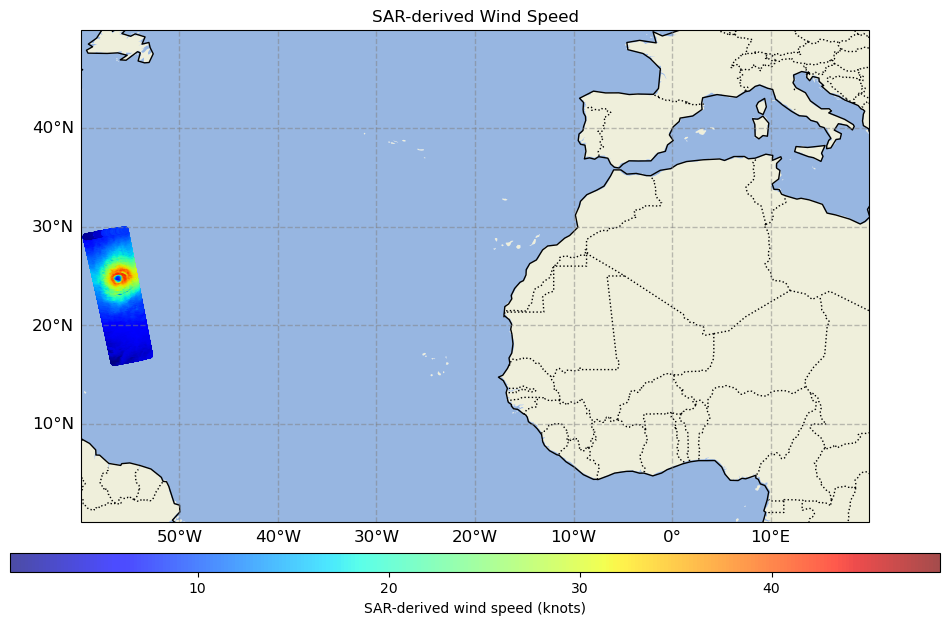

In [8]:

# Extract coordinates and wind speed
lon = ds['owiLon'].values.flatten()
lat = ds['owiLat'].values.flatten()
wind_speed = ds['owiWindSpeed'].values.flatten()

# Mask invalid data points
mask = np.isfinite(wind_speed) & np.isfinite(lon) & np.isfinite(lat)
lon, lat, wind_speed = lon[mask], lat[mask], wind_speed[mask]

# Set up the map with Cartopy
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.coastlines(resolution='110m')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.OCEAN)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = ccrs.cartopy.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = ccrs.cartopy.mpl.gridliner.LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

# Scatter plot of wind speed
sc = ax.scatter(lon, lat, c=wind_speed, cmap='jet', s=15, transform=ccrs.PlateCarree(), alpha=0.7)

# Add colorbar
cbar = plt.colorbar(sc, orientation='horizontal', pad=0.05, aspect=50, label='SAR-derived wind speed (knots)')

# Set extent (customize as needed)
ax.set_extent([-60, 20, 0, 50], crs=ccrs.PlateCarree())

# Title and annotations
ax.set_title('SAR-derived Wind Speed')

plt.show()